In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip')
print(data.shape)
print(data.sample(5))

(619040, 7)
              date   open   high     low  close   volume  Name
424708  2016-05-06  46.75  47.06  46.410  47.04  5507318   NWL
118496  2014-10-07  47.15  47.35  46.770  46.77   584875  CINF
486060  2015-02-02  53.10  53.35  51.960  53.26   583027   RJF
193874  2016-01-06  87.06  87.22  84.735  85.09  2759398    EL
206335  2015-07-17  30.25  30.46  29.950  30.18  2319579  ETFC


In [ ]:
data['date'] = pd.to_datetime(data['date'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB
None


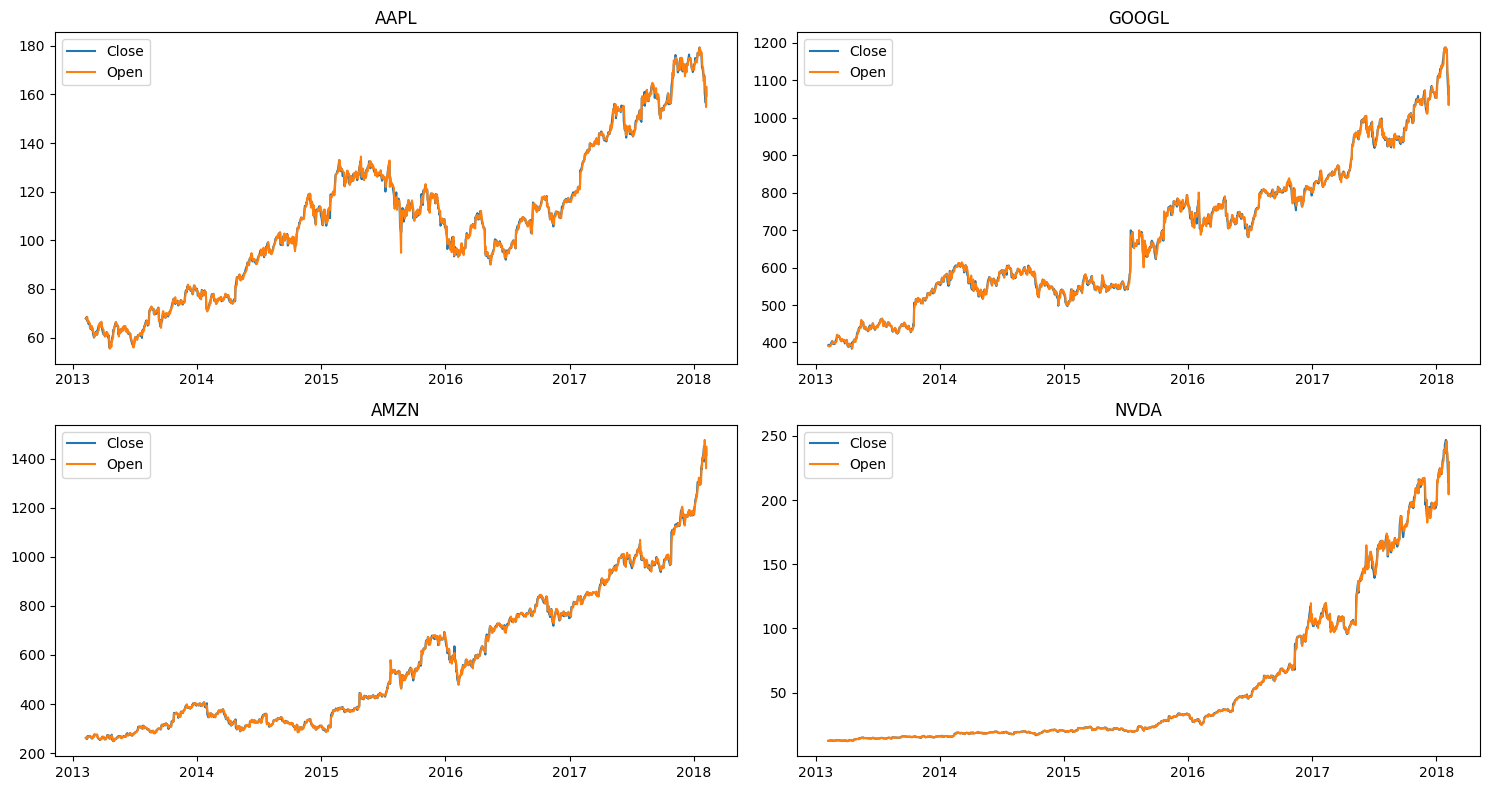

In [ ]:
companies = ['AAPL', 'GOOGL', 'AMZN', 'NVDA']

plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(2, 2, index)
    company_data = data[data['Name'] == company]
    plt.plot(company_data['date'], company_data['close'], label="Close")
    plt.plot(company_data['date'], company_data['open'], label="Open")
    plt.title(company)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
apple = data[data['Name'] == 'AAPL']
close_data = apple[['close']]
dataset = close_data.values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_len = int(len(scaled_data) * 0.95)
train_data = scaled_data[:training_len]

x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    keras.layers.LSTM(64),
    keras.layers.Dense(32),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(x_train, y_train, epochs=10)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10

36/3

2/2 [==============================] - 2s 20ms/step


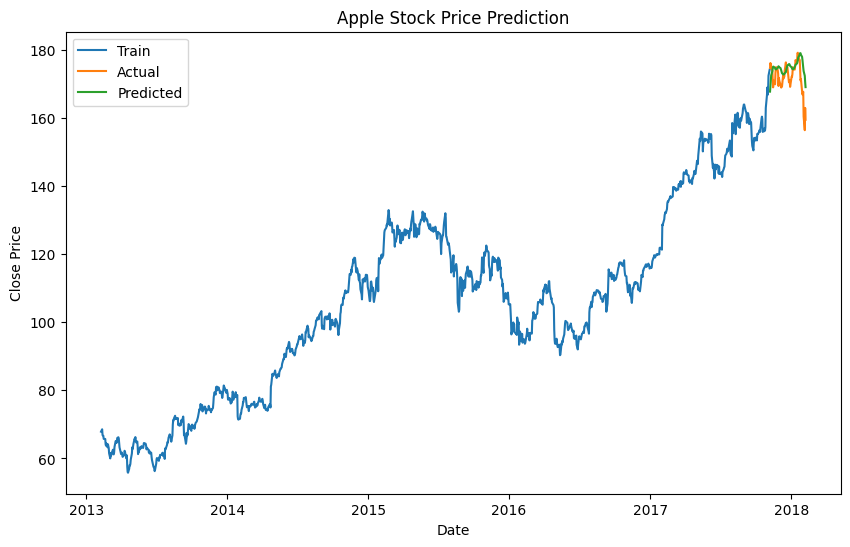

In [ ]:
test_data = scaled_data[training_len - 60:]
x_test = []
y_test = dataset[training_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot
train = apple[:training_len]
test = apple[training_len:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(['Train', 'Actual', 'Predicted'])
plt.show()